# Diabetes: Explorer Data Analysis

The dataset is part of a larger dataset held by the National Institutes of Diabetes and Digestive and Kidney Diseases in the US.

The data used for a diabetes study on Pima Indian women aged 21 and over living in Phoenix, the 5th largest city in the state of Arizona in the US.

The target variable is **"outcome"**, where **1** indicates a **positive diabetes** test result and **0** indicates a **negative** result.

In [3]:
# !pip install missingno
!pip install catboost
# !pip install lightgbm
# !pip install xgboost

## Importing Libraries

In [4]:

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
import missingno as msno
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Reading and Examination Dataset

In [5]:
df_ = pd.read_csv("diabetes.csv")
df =df_.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [8]:
df.shape

(768, 9)

In [9]:
df.dtypes

,0
Pregnancies,int64
Glucose,int64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64
Age,int64
Outcome,int64


## Detailed Analysis of Variable Types

In [10]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != 'O' and
                   dataframe[col].nunique() < cat_th]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == 'O' and
                   dataframe[col].nunique() > car_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols, num_cols, cat_but_car


In [11]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [12]:
cat_cols #Only our Target variable has the categorical feature.

['Outcome']

In [13]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

### Numerical Variables Analysis

In [14]:

def num_summary(dataframe, col, plot=False):
    quantiles = [0.05, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 0.95]
    print(dataframe[col].describe(quantiles).T)

    if plot:
      dataframe[col].hist()
      plt.xlabel(col)
      plt.title(col)
      plt.show()

Pregnancies
count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
25%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
75%        6.000000
90%        9.000000
95%       10.000000
max       17.000000
Name: Pregnancies, dtype: float64


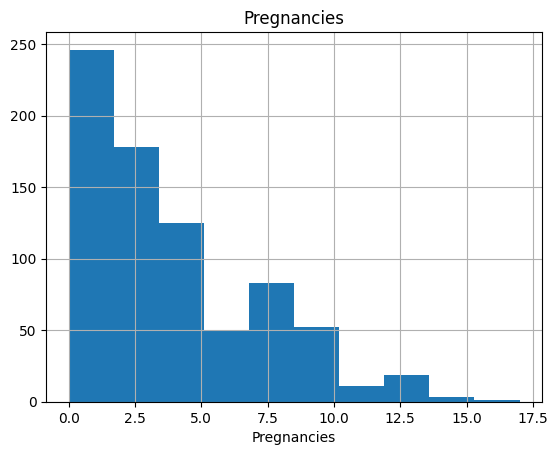


Glucose
count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
25%       99.000000
40%      109.000000
50%      117.000000
60%      125.000000
75%      140.250000
90%      167.000000
95%      181.000000
max      199.000000
Name: Glucose, dtype: float64


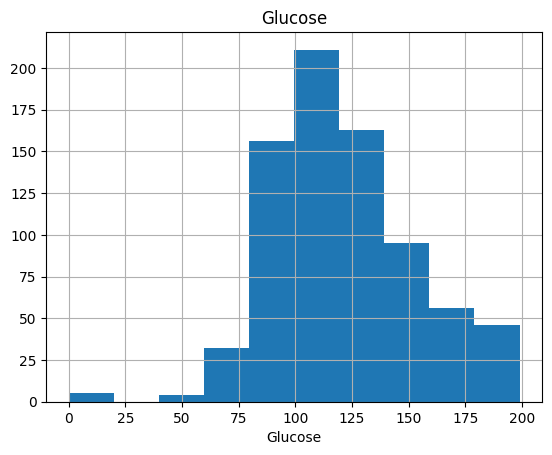


BloodPressure
count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
25%       62.000000
40%       68.000000
50%       72.000000
60%       74.000000
75%       80.000000
90%       88.000000
95%       90.000000
max      122.000000
Name: BloodPressure, dtype: float64


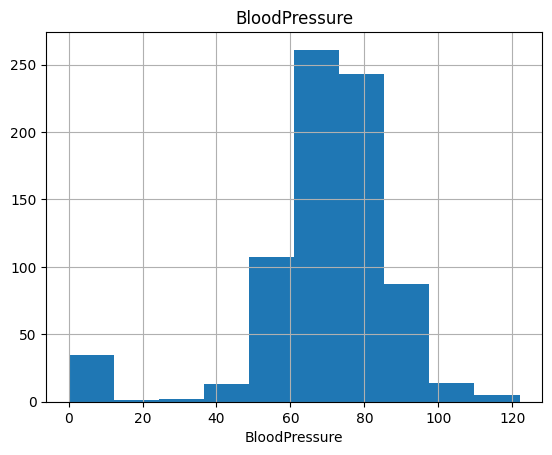


SkinThickness
count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
25%        0.000000
40%       18.000000
50%       23.000000
60%       27.000000
75%       32.000000
90%       40.000000
95%       44.000000
max       99.000000
Name: SkinThickness, dtype: float64


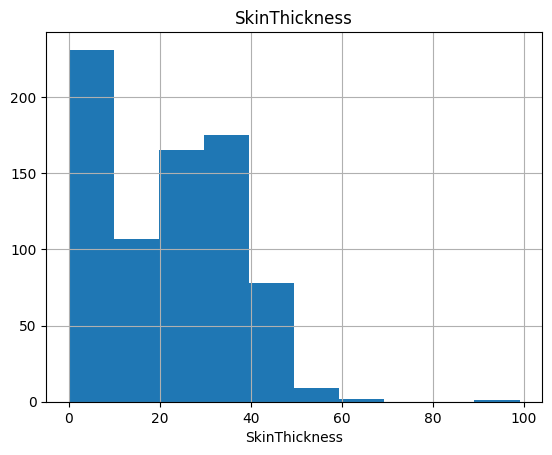


Insulin
count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
25%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
75%      127.250000
90%      210.000000
95%      293.000000
max      846.000000
Name: Insulin, dtype: float64


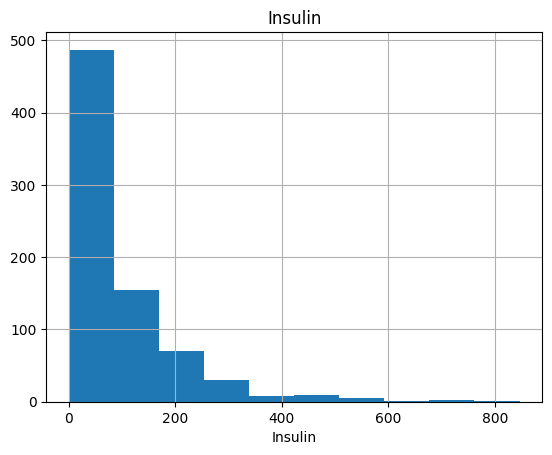


BMI
count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
25%       27.300000
40%       30.100000
50%       32.000000
60%       33.700000
75%       36.600000
90%       41.500000
95%       44.395000
max       67.100000
Name: BMI, dtype: float64


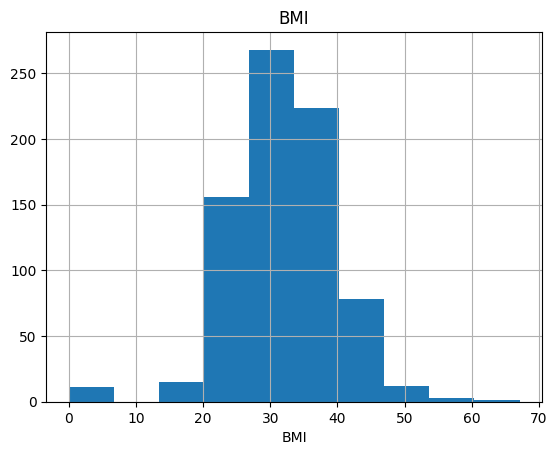


DiabetesPedigreeFunction
count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
25%        0.243750
40%        0.302800
50%        0.372500
60%        0.454200
75%        0.626250
90%        0.878600
95%        1.132850
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


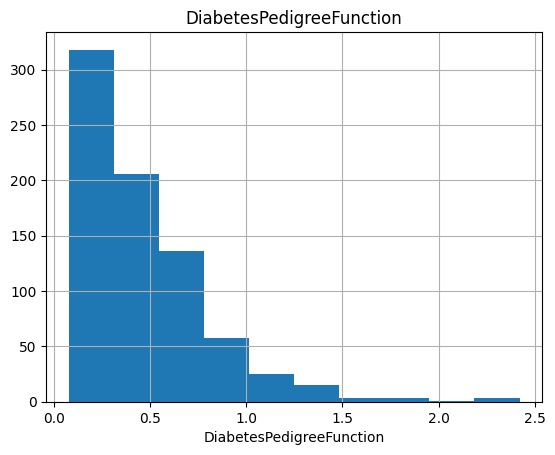


Age
count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
25%       24.000000
40%       27.000000
50%       29.000000
60%       33.000000
75%       41.000000
90%       51.000000
95%       58.000000
max       81.000000
Name: Age, dtype: float64


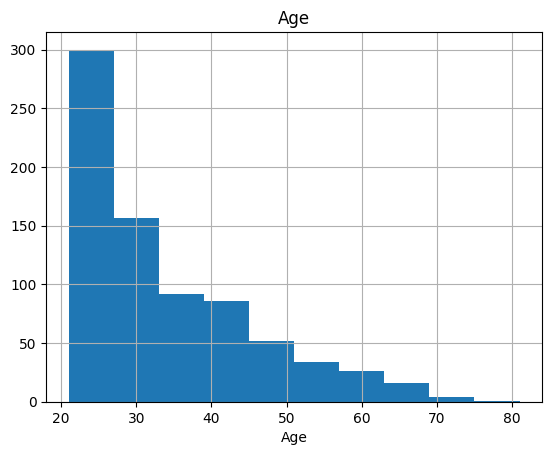

In [15]:
for col in df[num_cols]:
    print(col)
    num_summary(df, col, plot=True)
    print()

**Comment:**
1. In Glucose, min=0 but 5%=79. It is necessary to examine.
2. In Bloodpressure, min=0 it seems a mistake.
3. In BMI, min=0 it seems a mistake.
4. In SkinThickness, min=0 it seems a mistake.
5. In Insulin, it has 0 values.

### Average of Variables According to Values ​​of Target Variable

In [16]:
df.groupby("Outcome").agg({"Pregnancies":"mean",
                           "Glucose":"mean",
                           "BloodPressure":"mean",
                           "SkinThickness":"mean",
                           "Insulin":"mean",
                           "BMI":"mean",
                           "DiabetesPedigreeFunction":"mean",
                           "Age":"mean",})

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


### The Problem of Zero Values

In [17]:
# When we examine the values ​​in our dataset, we see some problems.
# Except for pregnancies and outcome variables, there are some values ​​that are zeros.
zero_columns = [col for col in df.columns if df[col].min() == 0 and col not in ["Outcome", "Pregnancies"]]

for col in zero_columns:
    df[col] = np.where(df[col] == 0 , np.nan, df[col])

In [18]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,763.0,121.686763,30.535641,44.000,99.00000,117.0000,141.00000,199.00
BloodPressure,733.0,72.405184,12.382158,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,541.0,29.153420,10.476982,7.000,22.00000,29.0000,36.00000,99.00
Insulin,394.0,155.548223,118.775855,14.000,76.25000,125.0000,190.00000,846.00
BMI,757.0,32.457464,6.924988,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [20]:
#Let's examine how many missing values ​​are in the rows.
df.isnull().sum(axis=1).value_counts().sort_index(ascending=False)

,count
4,7
3,28
2,199
1,142
0,392


In [21]:
df[df.isnull().sum(axis=1)==4]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
49,7,105.0,NaN,NaN,NaN,NaN,0.305,24,0
60,2,84.0,NaN,NaN,NaN,NaN,0.304,21,0
81,2,74.0,NaN,NaN,NaN,NaN,0.102,22,0
426,0,94.0,NaN,NaN,NaN,NaN,0.256,25,0
494,3,80.0,NaN,NaN,NaN,NaN,0.174,22,0
522,6,114.0,NaN,NaN,NaN,NaN,0.189,26,0
706,10,115.0,NaN,NaN,NaN,NaN,0.261,30,1


In [22]:
df[df.isnull().sum(axis=1)==3]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
7,10,115.0,NaN,NaN,NaN,35.3,0.134,29,0
9,8,125.0,96.0,NaN,NaN,NaN,0.232,54,1
15,7,100.0,NaN,NaN,NaN,30.0,0.484,32,1
78,0,131.0,NaN,NaN,NaN,43.2,0.270,26,1
193,11,135.0,NaN,NaN,NaN,52.3,0.578,40,1
222,7,119.0,NaN,NaN,NaN,25.2,0.209,37,0
261,3,141.0,NaN,NaN,NaN,30.0,0.761,27,1
266,0,138.0,NaN,NaN,NaN,36.3,0.933,25,1
269,2,146.0,NaN,NaN,NaN,27.5,0.240,28,1
300,0,167.0,NaN,NaN,NaN,32.3,0.839,30,1


## Advanced Analysis of Missing Values of The Dataset

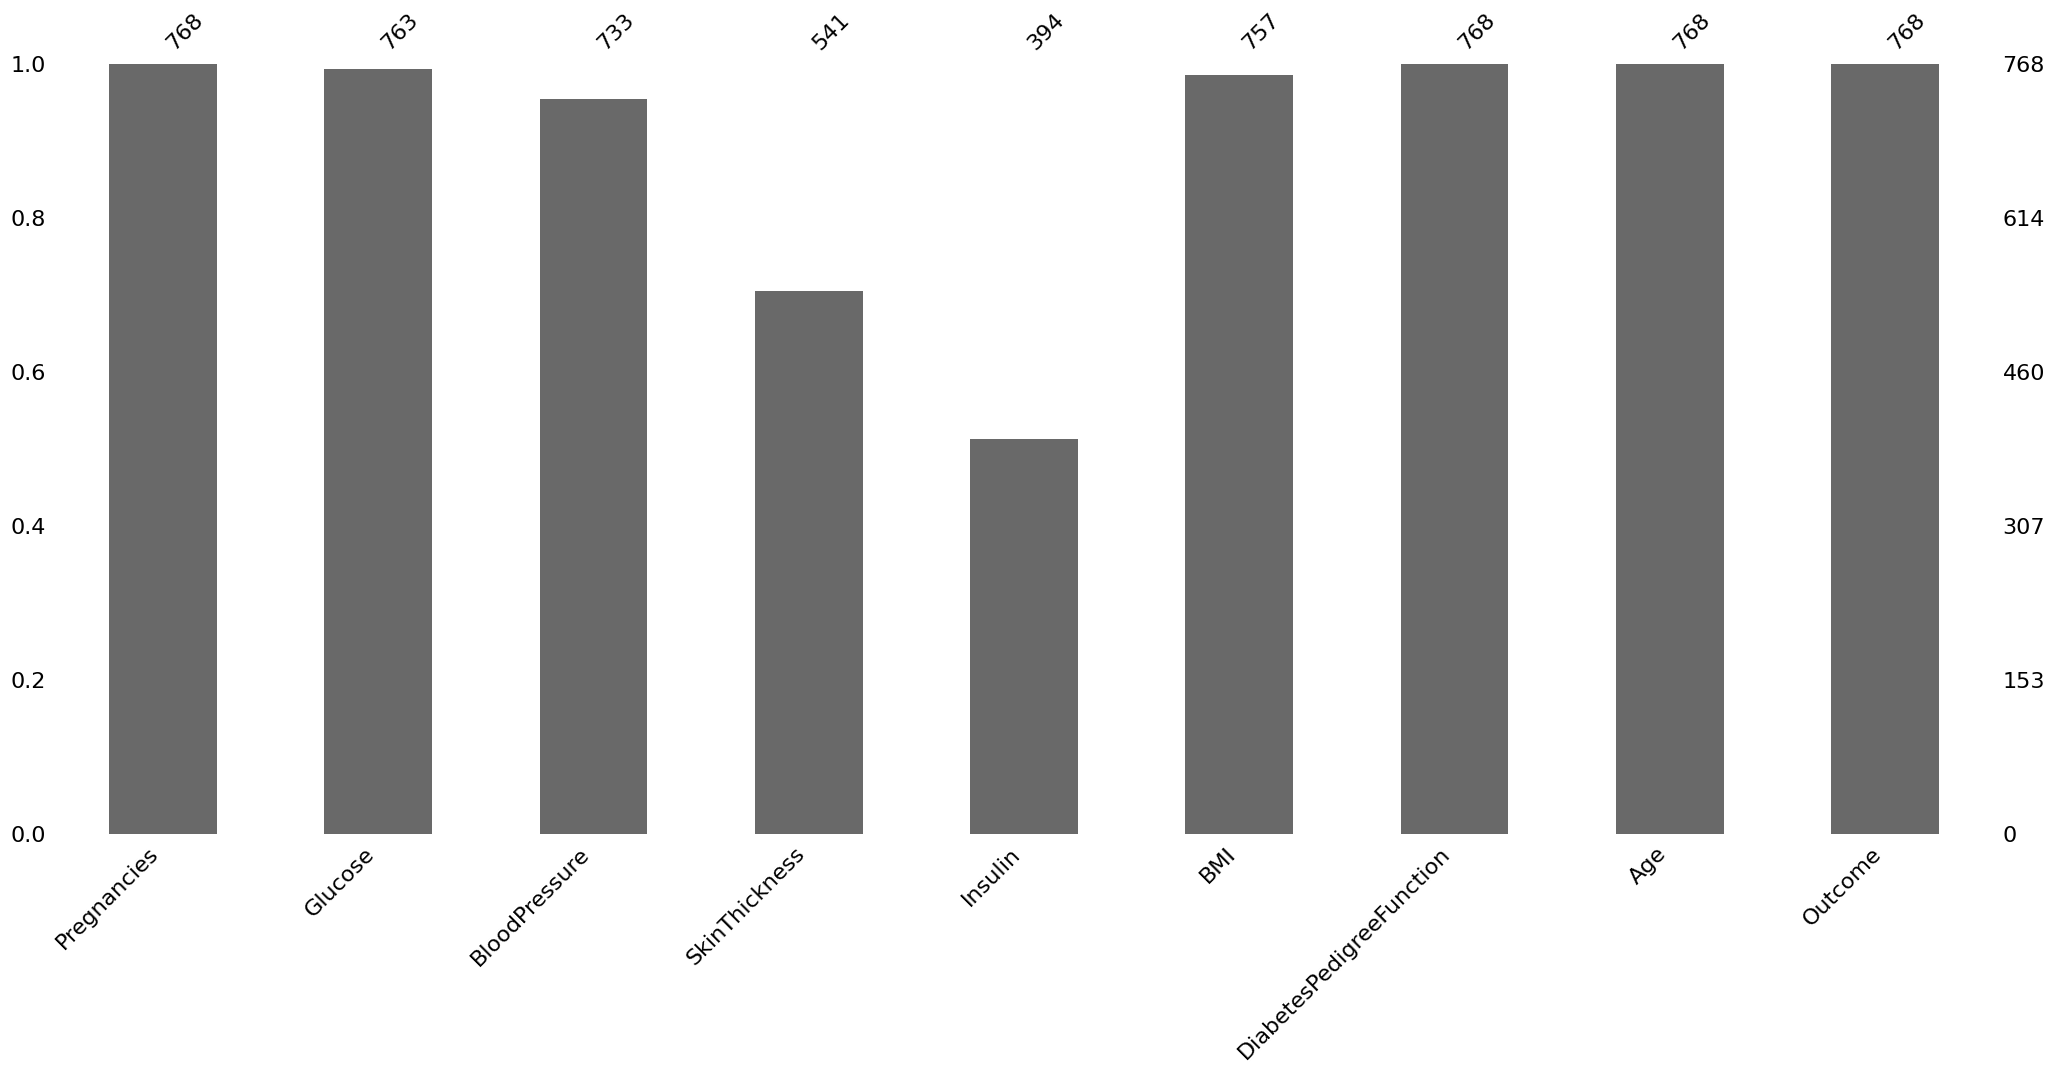

In [23]:
plt.figure(figsize=(12,8))
msno.bar(df)
plt.show()

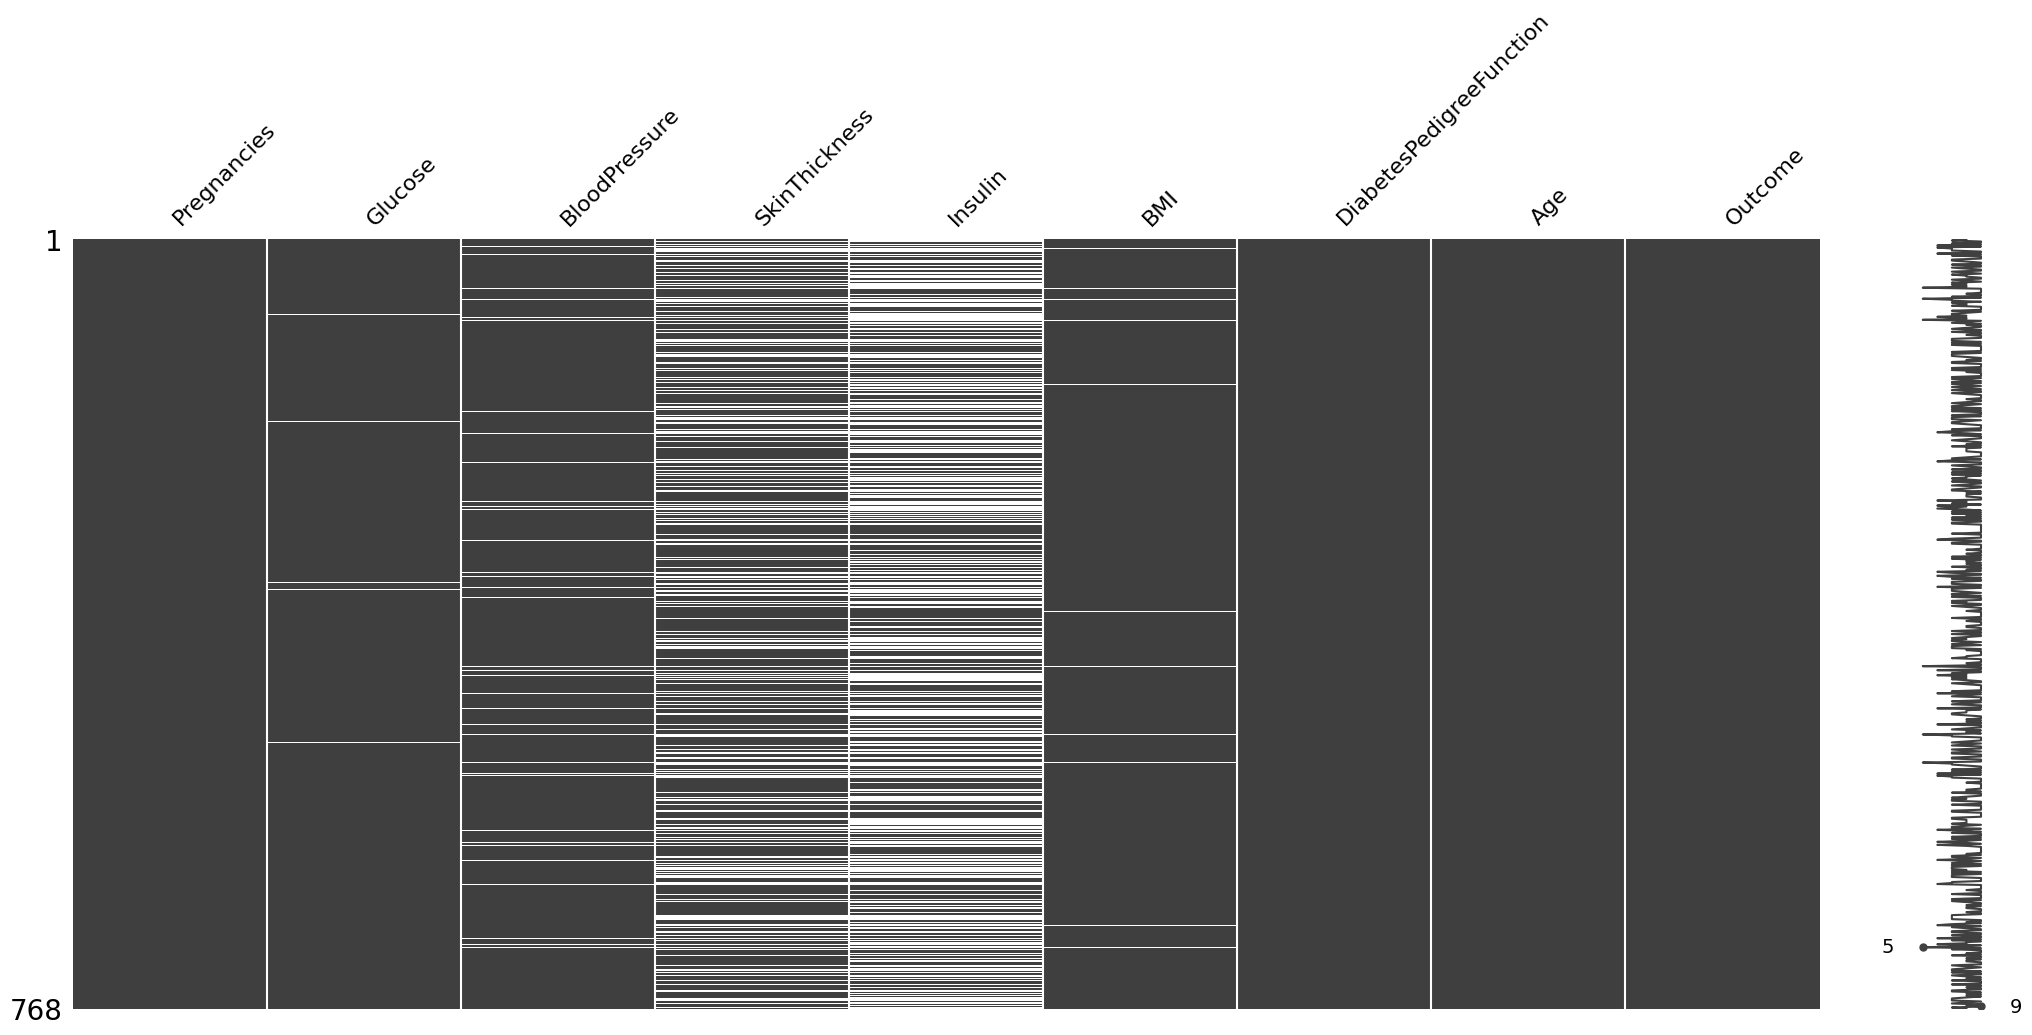

In [24]:
msno.matrix(df)
plt.show()

<Figure size 500x200 with 0 Axes>

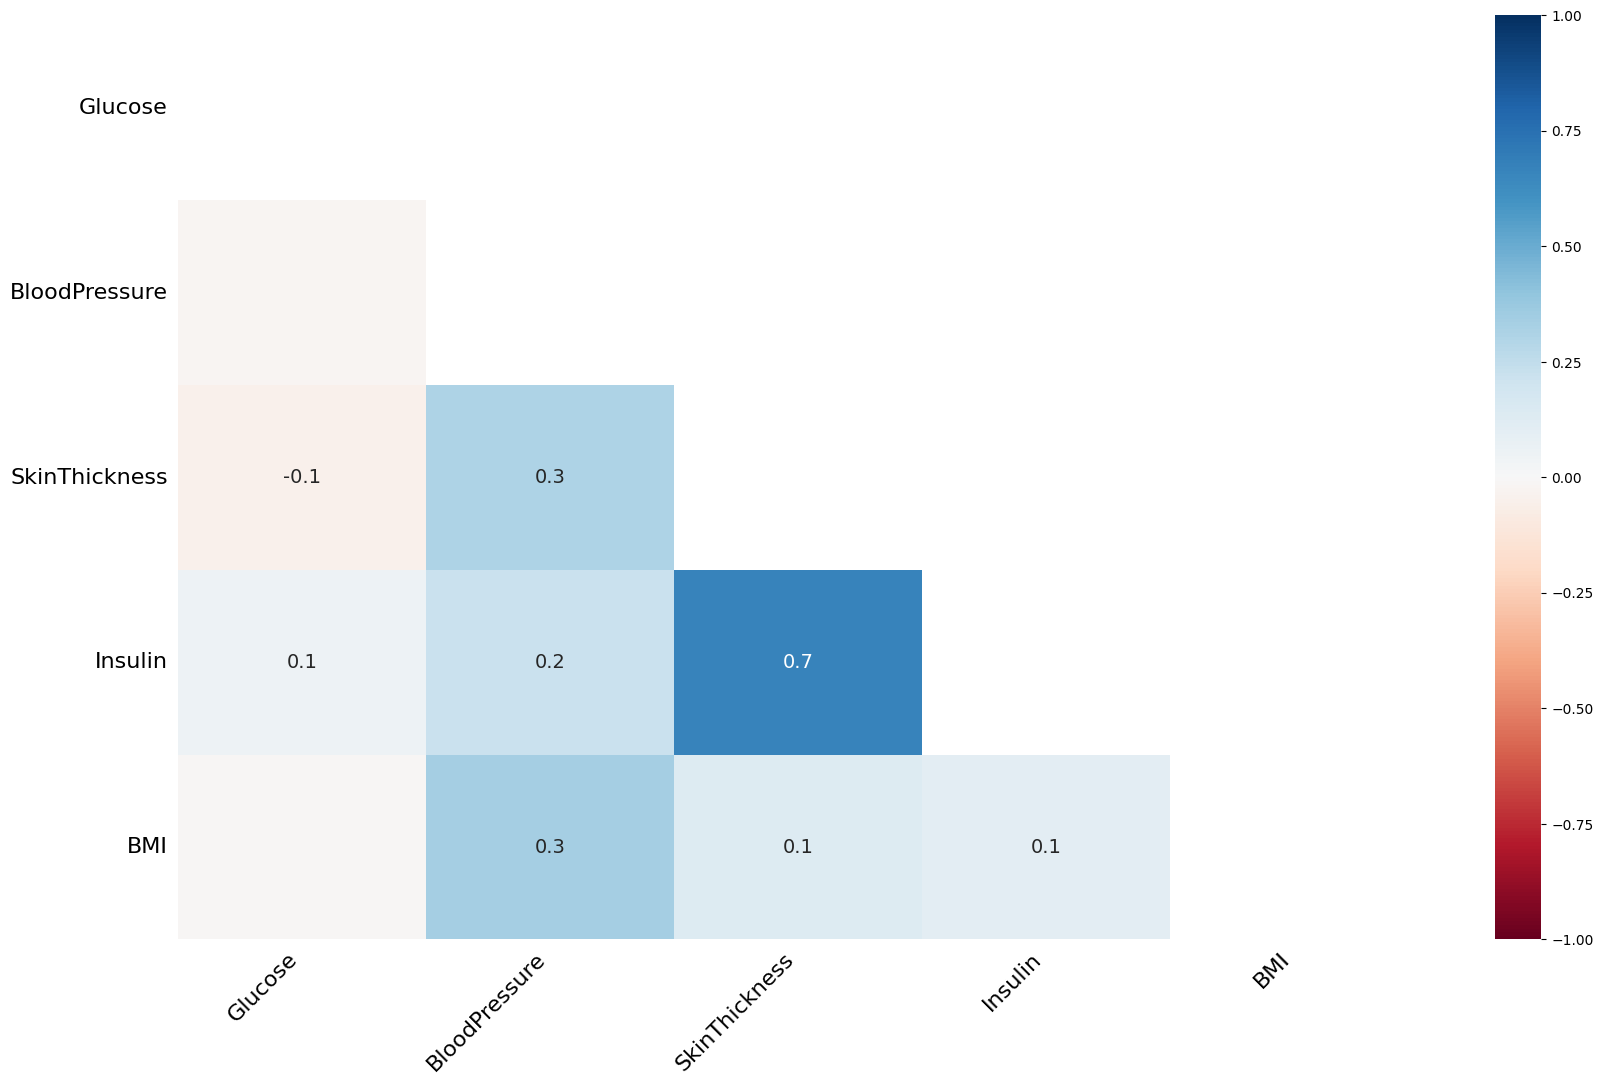

In [25]:
plt.figure(figsize=(5,2))
msno.heatmap(df)
plt.show()

**Relationship of Missing Values and Target**

In [26]:
def missing_values_table(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss  = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0]*100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio,2)], axis=1, keys= ['n_miss', 'ratio'])
  print(missing_df, end="\n")

  if na_name:
    return na_columns

na_cols = missing_values_table(df, na_name=True)

               n_miss  ratio
Insulin           374  48.70
SkinThickness     227  29.56
BloodPressure      35   4.56
BMI                11   1.43
Glucose             5   0.65


In [27]:
df['Glucose']= df['Glucose'].fillna(df.groupby('Outcome')['Glucose'].transform('mean'))
df['BloodPressure']= df['BloodPressure'].fillna(df.groupby('Outcome')['Glucose'].transform('mean'))
df['SkinThickness']= df['SkinThickness'].fillna(df.groupby('Outcome')['Glucose'].transform('mean'))
df['Insulin']= df['Insulin'].fillna(df.groupby('Outcome')['Glucose'].transform('mean'))
df['BMI']= df['BMI'].fillna(df.groupby('Outcome')['Glucose'].transform('mean'))

# Functional Alternative
#def groupby_assignment(dataframe, groupby_col, col):
   # dataframe[col].fillna(dataframe.groupby(groupby_col)[col].transform("mean"), inplace=True)


#for col in na_cols:
    #groupby_assignment(df, "Glucose",col )

df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0



## Corelation Analysis

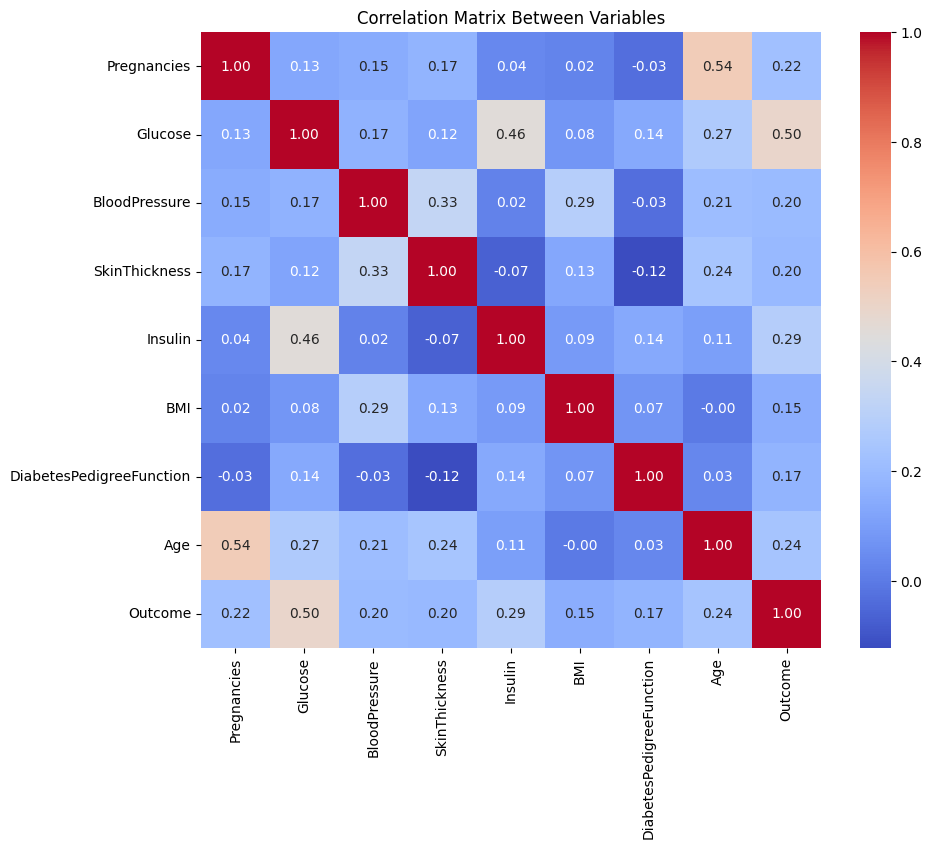

0

In [28]:
#Adım 7
corr_matrix = df.corr() #Default Method = 'pearson'
#corr_matrix = df.corr(method='spearman')
#corr_matrix = df.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Between Variables')
plt.show()

# Query of High Corelation
upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col]> 0.9)]
len(drop_list)

In [29]:
# Query of High Corelation
len(drop_list)

0

## Outliers

In [30]:
# This function allows us to observe outliers using the lower and upper limits we specify.
# We can also access the index information of outliers if we want.

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )].shape[0] > 10:
      print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )].head(10))
    else:
      print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )])
    if index:
      outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )].index
      return outlier_index


In [32]:
# This function outputs the lower and upper limits we set to catch outliers.
# Low limit and Upper Limit
def outlier_thresholds(dataframe, col_name,  q1=0.25, q3=0.75):
    Q1 = dataframe[col_name].quantile(q1)
    Q3 = dataframe[col_name].quantile(q3)
    IQR = Q3 - Q1
    low = Q1 - 1.5*IQR
    up = Q3 + 1.5*IQR
    return low, up

In [33]:
number =1
for col in num_cols:
    print(number, '.', col.upper(), end='\n\n')
    grab_outliers(df, col)
    print( '\n#################\n', end='\n')
    number += 1

1 . PREGNANCIES

     Pregnancies  Glucose  BloodPressure  SkinThickness     Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
88            15    136.0           70.0           32.0  110.000000  37.1                     0.153   43        1
159           17    163.0           72.0           41.0  114.000000  40.9                     0.817   47        1
298           14    100.0           78.0           25.0  184.000000  36.6                     0.412   46        1
455           14    175.0           62.0           30.0  142.319549  33.6                     0.212   38        1

#################

2 . GLUCOSE

Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []

#################

3 . BLOODPRESSURE

     Pregnancies  Glucose  BloodPressure  SkinThickness     Insulin         BMI  DiabetesPedigreeFunction  Age  Outcome
7             10    115.0     110.643863     110.643863  110.643863   35.300000

In [34]:
# Re-assignment with Thresholds
def replace_with_thresholds(dataframe, col):
    low, up = outlier_thresholds(dataframe,col)
    dataframe.loc[dataframe[col] < low, col] = low
    dataframe.loc[dataframe[col] > up, col] = up

replace_with_thresholds(df,"Pregnancies")
replace_with_thresholds(df,"BloodPressure")
replace_with_thresholds(df,"SkinThickness")
replace_with_thresholds(df,"Insulin")
replace_with_thresholds(df,"BMI")
replace_with_thresholds(df,"DiabetesPedigreeFunction")
replace_with_thresholds(df,"Age")

<ipython-input-34-db827ecc7d1a>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-6.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[dataframe[col] < low, col] = low
<ipython-input-34-db827ecc7d1a>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[dataframe[col] < low, col] = low


## Feature Engineering

In [35]:
df["Age_new"] = pd.cut(df["Age"], bins=[20, 24, 28, 40, 55, 60, 100])
df.groupby("Age_new").agg({"Outcome": ["mean", "count"],
                           "Insulin":["mean", "count"],
                           "BloodPressure":["mean", "count"],
                           "SkinThickness":["mean", "count"]})

<ipython-input-35-7c24cf2f988d>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Age_new").agg({"Outcome": ["mean", "count"],


Outcome           Insulin       BloodPressure       SkinThickness      
               mean count        mean count          mean count          mean count
Age_new                                                                            
(20, 24]   0.141553   219  115.690367   219     69.260274   219     41.119910   219
(24, 28]   0.270270   148  118.914485   148     72.290541   148     51.661729   148
(28, 40]   0.458937   207  131.000585   207     75.787440   207     63.821160   207
(40, 55]   0.590278   144  134.521501   144     79.312500   144     69.124797   144
(55, 60]   0.434783    23  145.734564    23     77.521739    23     59.934882    23
(60, 100]  0.259259    27  122.597997    27     79.074074    27     91.887702    27

In [36]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.837240,3.344157,0.000000,1.000000,3.000000,6.000000,13.500000
Glucose,768.0,121.697358,30.462008,44.000000,99.750000,117.000000,141.000000,199.000000
BloodPressure,768.0,74.080729,14.125116,37.000000,64.000000,73.000000,82.000000,109.000000
SkinThickness,768.0,56.869293,44.507366,7.000000,25.000000,35.000000,110.643863,142.319549
Insulin,768.0,125.111709,37.155417,63.130335,110.643863,110.643863,142.319549,189.833077
BMI,768.0,32.664372,7.032775,18.200000,27.500000,32.400000,36.825000,50.812500
DiabetesPedigreeFunction,768.0,0.458914,0.285596,0.078000,0.243750,0.372500,0.626250,1.200000
Age,768.0,33.199870,11.628404,21.000000,24.000000,29.000000,41.000000,66.500000
Outcome,768.0,0.348958,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000


In [37]:
df["Pregnancies_new"] = pd.cut(df["Pregnancies"], bins=[-1, 0.9, 1.9, 2.9, 4.9, 7.9, 100], labels=[0, 1, 2, "3-4","5-7","8+"])

df.loc[df["Glucose"] < 70, "Glucose_new"] = "Low"
df.loc[(df["Glucose"]) >= 70 & (df["Glucose"] <= 140), "Glucose_new"] = "Normal"
df.loc[df["Glucose"] > 140, "Glucose_new"] = "High"

df.loc[df["BloodPressure"] < 60, "BloodPressure_new"] = "Low"
df.loc[(df["BloodPressure"] >= 60) & (df["BloodPressure"] <= 100), "BloodPressure_new"] = "Normal"
df.loc[df["BloodPressure"] > 100, "BloodPressure_new"] = "High"

df.loc[df["Insulin"] < 100, "Insulin_new"] = "Low"
df.loc[(df["Insulin"] >= 100) & (df["Insulin"] <= 140), "Insulin_new"] = "Normal"
df.loc[df["Insulin"] > 140, "Insulin_new"] = "High"


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    float64 
 1   Glucose                   768 non-null    float64 
 2   BloodPressure             768 non-null    float64 
 3   SkinThickness             768 non-null    float64 
 4   Insulin                   768 non-null    float64 
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    float64 
 8   Outcome                   768 non-null    int64   
 9   Age_new                   768 non-null    category
 10  Pregnancies_new           768 non-null    category
 11  Glucose_new               768 non-null    object  
 12  BloodPressure_new         768 non-null    object  
 13  Insulin_new               768 non-null    object  

## Encoding

In [39]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 14
cat_cols: 6
num_cols: 8
cat_but_car: 0
num_but_cat: 3


In [40]:
cat_cols

['Glucose_new',
 'BloodPressure_new',
 'Insulin_new',
 'Outcome',
 'Age_new',
 'Pregnancies_new']

In [41]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

### Label Encoding

In [42]:
#Pregnancies_new Label Encoding
label_mapping = {0 : 0, 1: 1, 2: 2, '3-4': 3, '5-7': 4, '8+': 5}
df['Pregnancies_new'] = df['Pregnancies_new'].map(label_mapping)

### One Hot Encoding

In [43]:
cat_cols = [col for col in cat_cols if col!= 'Pregnancies_new']

In [44]:
cat_cols

['Glucose_new', 'BloodPressure_new', 'Insulin_new', 'Outcome', 'Age_new']

In [45]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

## Scaling

In [50]:
X_scaled = MinMaxScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies_new,Glucose_new_Normal,BloodPressure_new_Low,BloodPressure_new_Normal,Insulin_new_Low,Insulin_new_Normal,Outcome_1,"Age_new_(24, 28]","Age_new_(28, 40]","Age_new_(40, 55]","Age_new_(55, 60]","Age_new_(60, 100]"
0,0.444444,0.670968,0.486111,0.206918,0.625000,0.472212,0.489305,0.637363,0.8,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.074074,0.264516,0.402778,0.162578,0.375000,0.257570,0.243316,0.219780,0.2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.592593,0.896774,0.375000,1.000000,0.625000,0.156382,0.529412,0.241758,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.074074,0.290323,0.402778,0.118239,0.243638,0.303565,0.079323,0.000000,0.2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.600000,0.041667,0.206918,0.827683,0.763511,1.000000,0.263736,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [53]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Pregnancies_new', 'Glucose_new_Normal', 'BloodPressure_new_Low', 'BloodPressure_new_Normal', 'Insulin_new_Low', 'Insulin_new_Normal', 'Outcome_1', 'Age_new_(24, 28]', 'Age_new_(28, 40]', 'Age_new_(40, 55]', 'Age_new_(55, 60]', 'Age_new_(60, 100]'], dtype='object')

## Base Models

In [57]:
X = df.drop(columns='Outcome')
y = df['Outcome']

models = [('LR', LogisticRegression(random_state=123)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=123)),
          ('RF', RandomForestClassifier(random_state=123)),
          ('SVM', SVC(gamma='auto', random_state=123)),
          #('XGB', XGBClassifier(random_state=123)),
          #("LightGBM", LGBMClassifier(random_state=123)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=1))]

for name, model in models:
    cv_results = cross_validate(
        model, X, y, cv=10, scoring=['accuracy', 'f1', 'roc_auc', 'precision', 'recall']
    )
    print(f"###  {name}  ###")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"F1 Score: {round(cv_results['test_f1'].mean(), 4)}")
    print(f"Roc_Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")


###  LR  ###
Accuracy: 0.8724
F1 Score: 0.813
Roc_Auc: 0.9224
Precision: 0.8294
Recall: 0.8021
###  KNN  ###
Accuracy: 0.858
F1 Score: 0.7822
Roc_Auc: 0.8953
Precision: 0.8368
Recall: 0.7386
###  CART  ###
Accuracy: 0.8477
F1 Score: 0.7829
Roc_Auc: 0.8356
Precision: 0.7795
Recall: 0.7952
###  RF  ###
Accuracy: 0.8867
F1 Score: 0.8302
Roc_Auc: 0.9529
Precision: 0.8635
Recall: 0.806
###  SVM  ###
Accuracy: 0.841
F1 Score: 0.7845
Roc_Auc: 0.9162
Precision: 0.7448
Recall: 0.8356
###  CatBoost  ###
Accuracy: 0.8829
F1 Score: 0.8258
Roc_Auc: 0.9556
Precision: 0.854
Recall: 0.8063


## Automated Hyperparameter Optimization

In [60]:
knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 12, 15, 18, None],
             "max_features": [6, 7, 8, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [150, 200, 250]}

#xgboost_params = {"learning_rate": [0.1, 0.01],
#                  "max_depth": [5, 8],
#                  "n_estimators": [100, 200]}

#lightgbm_params = {"learning_rate": [0.01, 0.1],
   #                "n_estimators": [300, 500]}


classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               #('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
             #  ('LightGBM', LGBMClassifier(), lightgbm_params)
             ]



def hyperparameter_optimization(X, y, cv=3, scoring='accuracy'):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization....
########## KNN ##########
accuracy (Before): 0.8607
accuracy (After): 0.8711
KNN best params: {'n_neighbors': 9}

########## CART ##########
accuracy (Before): 0.8581
accuracy (After): 0.8724
CART best params: {'max_depth': 13, 'min_samples_split': 11}

########## RF ##########
accuracy (Before): 0.8802


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
90 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

accuracy (After): 0.8919
RF best params: {'max_depth': 18, 'max_features': 8, 'min_samples_split': 20, 'n_estimators': 150}



## Final Result

* Best Method: RandomForestClassifier

* Accuracy Score: 0.8919

* Best Parameters: 'max_depth': 18, 'max_features': 8, 'min_samples_split': 20, 'n_estimators': 150